In [1]:
!pip install calplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import folium
from folium import plugins
from folium.plugins import HeatMap

import calplot

plt.rcParams['axes.facecolor'] = "#E8ECEB"
plt.rcParams['axes.facecolor'] = "#E8ECEB"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

datasets_path = '/content/drive/MyDrive/Colab Notebooks/datasets/socialdata'
file_path = "311_Cases_gustav.csv"
dataset_path = os.path.join(datasets_path, file_path)

df = pd.read_csv(dataset_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-cb9a804125f4>:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


,Unnamed: 0,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Latitude,Longitude,Source,Media URL,yearmonth
0,58,2008-11-10 08:10:22,11/12/2008 03:06:59 PM,11/12/2008 03:06:59 PM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,"28 13TH ST, SAN FRANCISCO, CA, 94103",6.0,South of Market,37.769745,-122.413742,Phone,NaN,2008-11-01
1,83,2008-10-27 13:07:52,11/27/2008 02:07:00 PM,11/27/2008 02:07:00 PM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,"327 LINDEN ST, SAN FRANCISCO, CA, 94102",5.0,Hayes Valley,37.776325,-122.423264,Phone,NaN,2008-10-01
2,204,2008-10-11 08:45:39,10/15/2008 09:37:00 AM,10/15/2008 09:37:00 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,"Furniture, Mattresses and Refrigerators",Intersection of BURROWS ST and GOETTINGEN ST,9.0,Portola,37.728058,-122.407059,Phone,NaN,2008-10-01
3,541,2008-11-13 09:03:38,11/13/2008 11:06:56 AM,11/13/2008 11:06:56 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,Intersection of JUNIPERO SERRA BLVD and SLOAT ...,7.0,Merced Manor,37.734707,-122.471573,Phone,NaN,2008-11-01
4,584,2008-10-13 12:46:42,10/14/2008 06:06:54 AM,10/14/2008 06:06:54 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,"Furniture, Mattresses and Refrigerators",Intersection of LEAVENWORTH ST and SUTTER ST,3.0,Lower Nob Hill,37.788387,-122.415184,Phone,NaN,2008-10-01


## Week 2 exploratory analyisis

## Helper functions

In [5]:
def get_top_categories(df, top_n=10):
    """
    Returns a list of the top n categories based on the count of their occurrences in the input dataframe.

    Parameters:
    df (pandas.DataFrame): Input dataframe.
    top_n (int): Number of top categories to return.

    Returns:
    list: List of top n categories.
    """
    category_counts = df['Request Details'].value_counts()
    top_categories = category_counts.iloc[:top_n].index.tolist()
    return top_categories

def plot_category_subset(period_col, df, focus_categories, plt_title, ylabel, xlabel, xticks, xticklabels):
    grouped = df.groupby(['Request Details', period_col])['Opened'].agg('count')
    # Note that the reset_index method is used to reset the index of the grouped data to 
    # default (0, 1, 2, ...). This is because the result of a groupby and aggregate operation  
    # often has a MultiIndex, which is not convenient for accessing values.
    focus_subset = grouped[focus_categories].reset_index()

    # Sort values by Category and period columns
    focus_subset = focus_subset.sort_values(['Request Details', period_col])

    # Plot data
    cols = 2
    fig, axs = plt.subplots(int(len(focus_categories)/cols), cols, figsize=(15,20))
    axs = axs.flatten()

    for i, category in enumerate(focus_categories):
        category_data = focus_subset[focus_subset['Request Details'] == category]
        axs[i].bar(category_data[period_col], category_data['Opened'], width=0.5, edgecolor='indigo', color='lavender')

        axs[i].set_title(category, x=0.05, y=0.85, horizontalalignment='left')
        axs[i].set_ylabel(ylabel)
        axs[i].set_xticks([])
        axs[i].set_ylim(0, category_data.Opened.max()*1.4)

        # Show xlabels for the last row in the plot
        if i >= len(focus_categories) - cols:
            axs[i].set_xlabel(xlabel)
            axs[i].set_xticks(xticks)
            axs[i].set_xticklabels(xticklabels, rotation=45)

    plt.suptitle(plt_title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # avoid text overlapping
    plt.show()

### Apply time transformations and define focus categories

In [6]:
# Focus categories (top 12 more reported)
focus_categories = get_top_categories(df, 12)

# Create date and time columns
df['Opened'] = pd.to_datetime(df['Opened'], format='%Y-%m-%d %H:%M:%S')
df['Date'] = df['Opened'].dt.date
df['Time'] = df['Opened'].dt.time

# Create 'DayOfWeek' column
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.strftime('%A')

df.head()

,Unnamed: 0,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Supervisor District,Neighborhood,Latitude,Longitude,Source,Media URL,yearmonth,Date,Time,DayOfWeek
0,58,2008-11-10 08:10:22,11/12/2008 03:06:59 PM,11/12/2008 03:06:59 PM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,...,6.0,South of Market,37.769745,-122.413742,Phone,NaN,2008-11-01,2008-11-10,08:10:22,Monday
1,83,2008-10-27 13:07:52,11/27/2008 02:07:00 PM,11/27/2008 02:07:00 PM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,...,5.0,Hayes Valley,37.776325,-122.423264,Phone,NaN,2008-10-01,2008-10-27,13:07:52,Monday
2,204,2008-10-11 08:45:39,10/15/2008 09:37:00 AM,10/15/2008 09:37:00 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,"Furniture, Mattresses and Refrigerators",...,9.0,Portola,37.728058,-122.407059,Phone,NaN,2008-10-01,2008-10-11,08:45:39,Saturday
3,541,2008-11-13 09:03:38,11/13/2008 11:06:56 AM,11/13/2008 11:06:56 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Loose Garbage and Debris,...,7.0,Merced Manor,37.734707,-122.471573,Phone,NaN,2008-11-01,2008-11-13,09:03:38,Thursday
4,584,2008-10-13 12:46:42,10/14/2008 06:06:54 AM,10/14/2008 06:06:54 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,"Furniture, Mattresses and Refrigerators",...,3.0,Lower Nob Hill,37.788387,-122.415184,Phone,NaN,2008-10-01,2008-10-13,12:46:42,Monday


### N. of requests per week-day by category

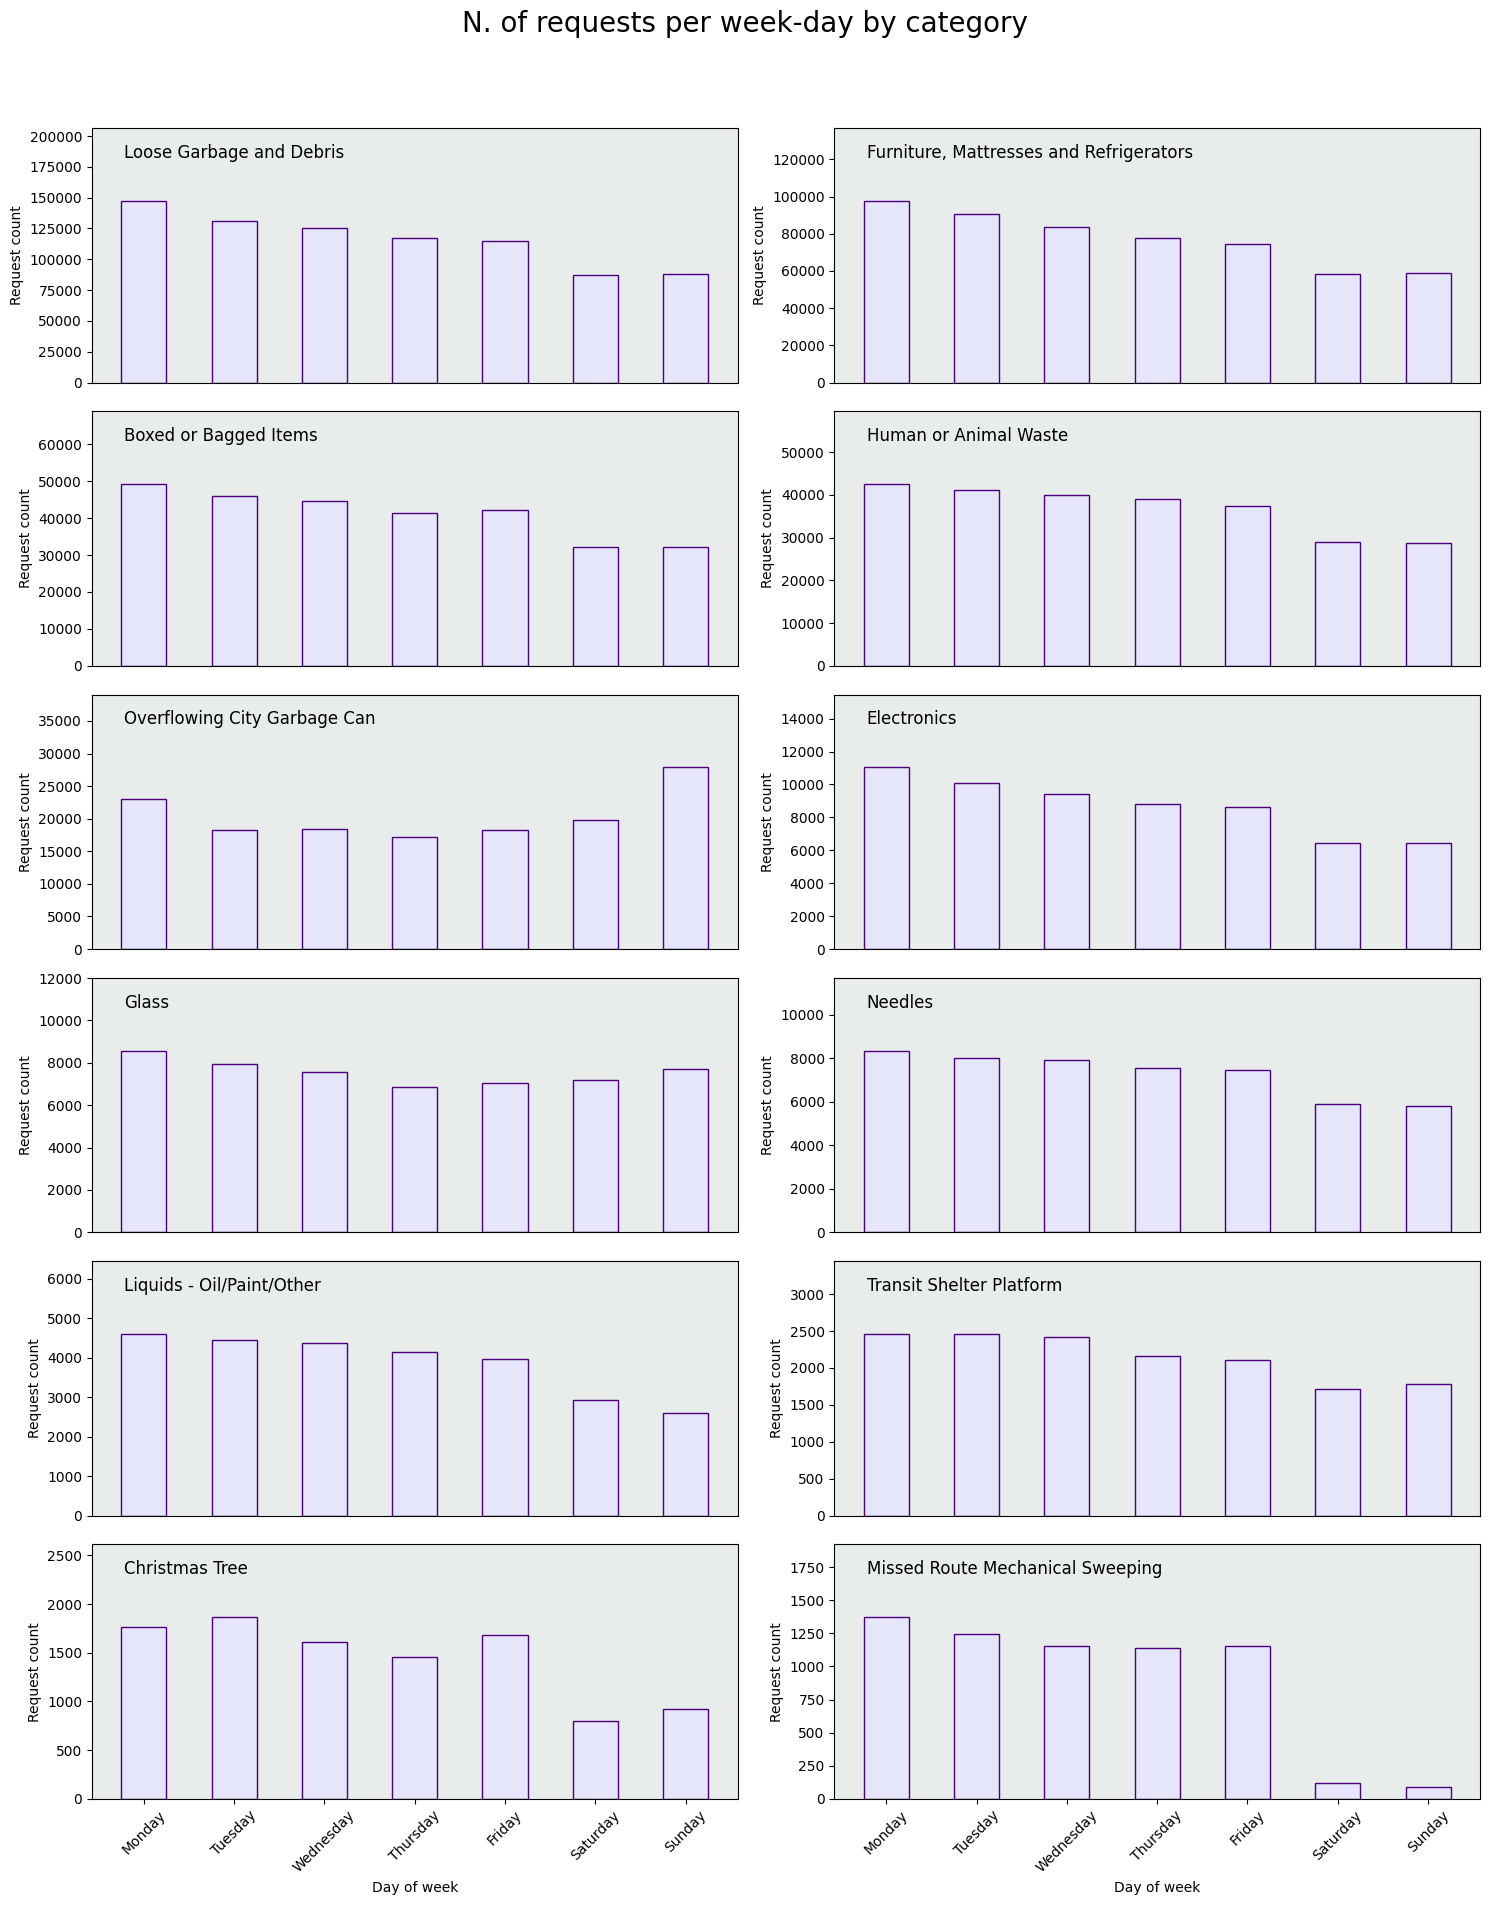

In [7]:
# Define optional custom order for DayOfWeek column
ordered_days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order = pd.CategoricalDtype(ordered_days, ordered=True)

# Convert DayOfWeek column to categorical data type with custom order
custom_df = df.copy()
custom_df['DayOfWeek'] = custom_df['DayOfWeek'].astype(day_order)

# Define custom variables
plt_title = 'N. of requests per week-day by category'
ylabel = 'Request count'
xlabel = 'Day of week'
xticks = ordered_days
xticklabels = ordered_days

# Plot data
plot_category_subset('DayOfWeek', custom_df, focus_categories, plt_title, ylabel, xlabel, xticks, xticklabels)

### Month plots

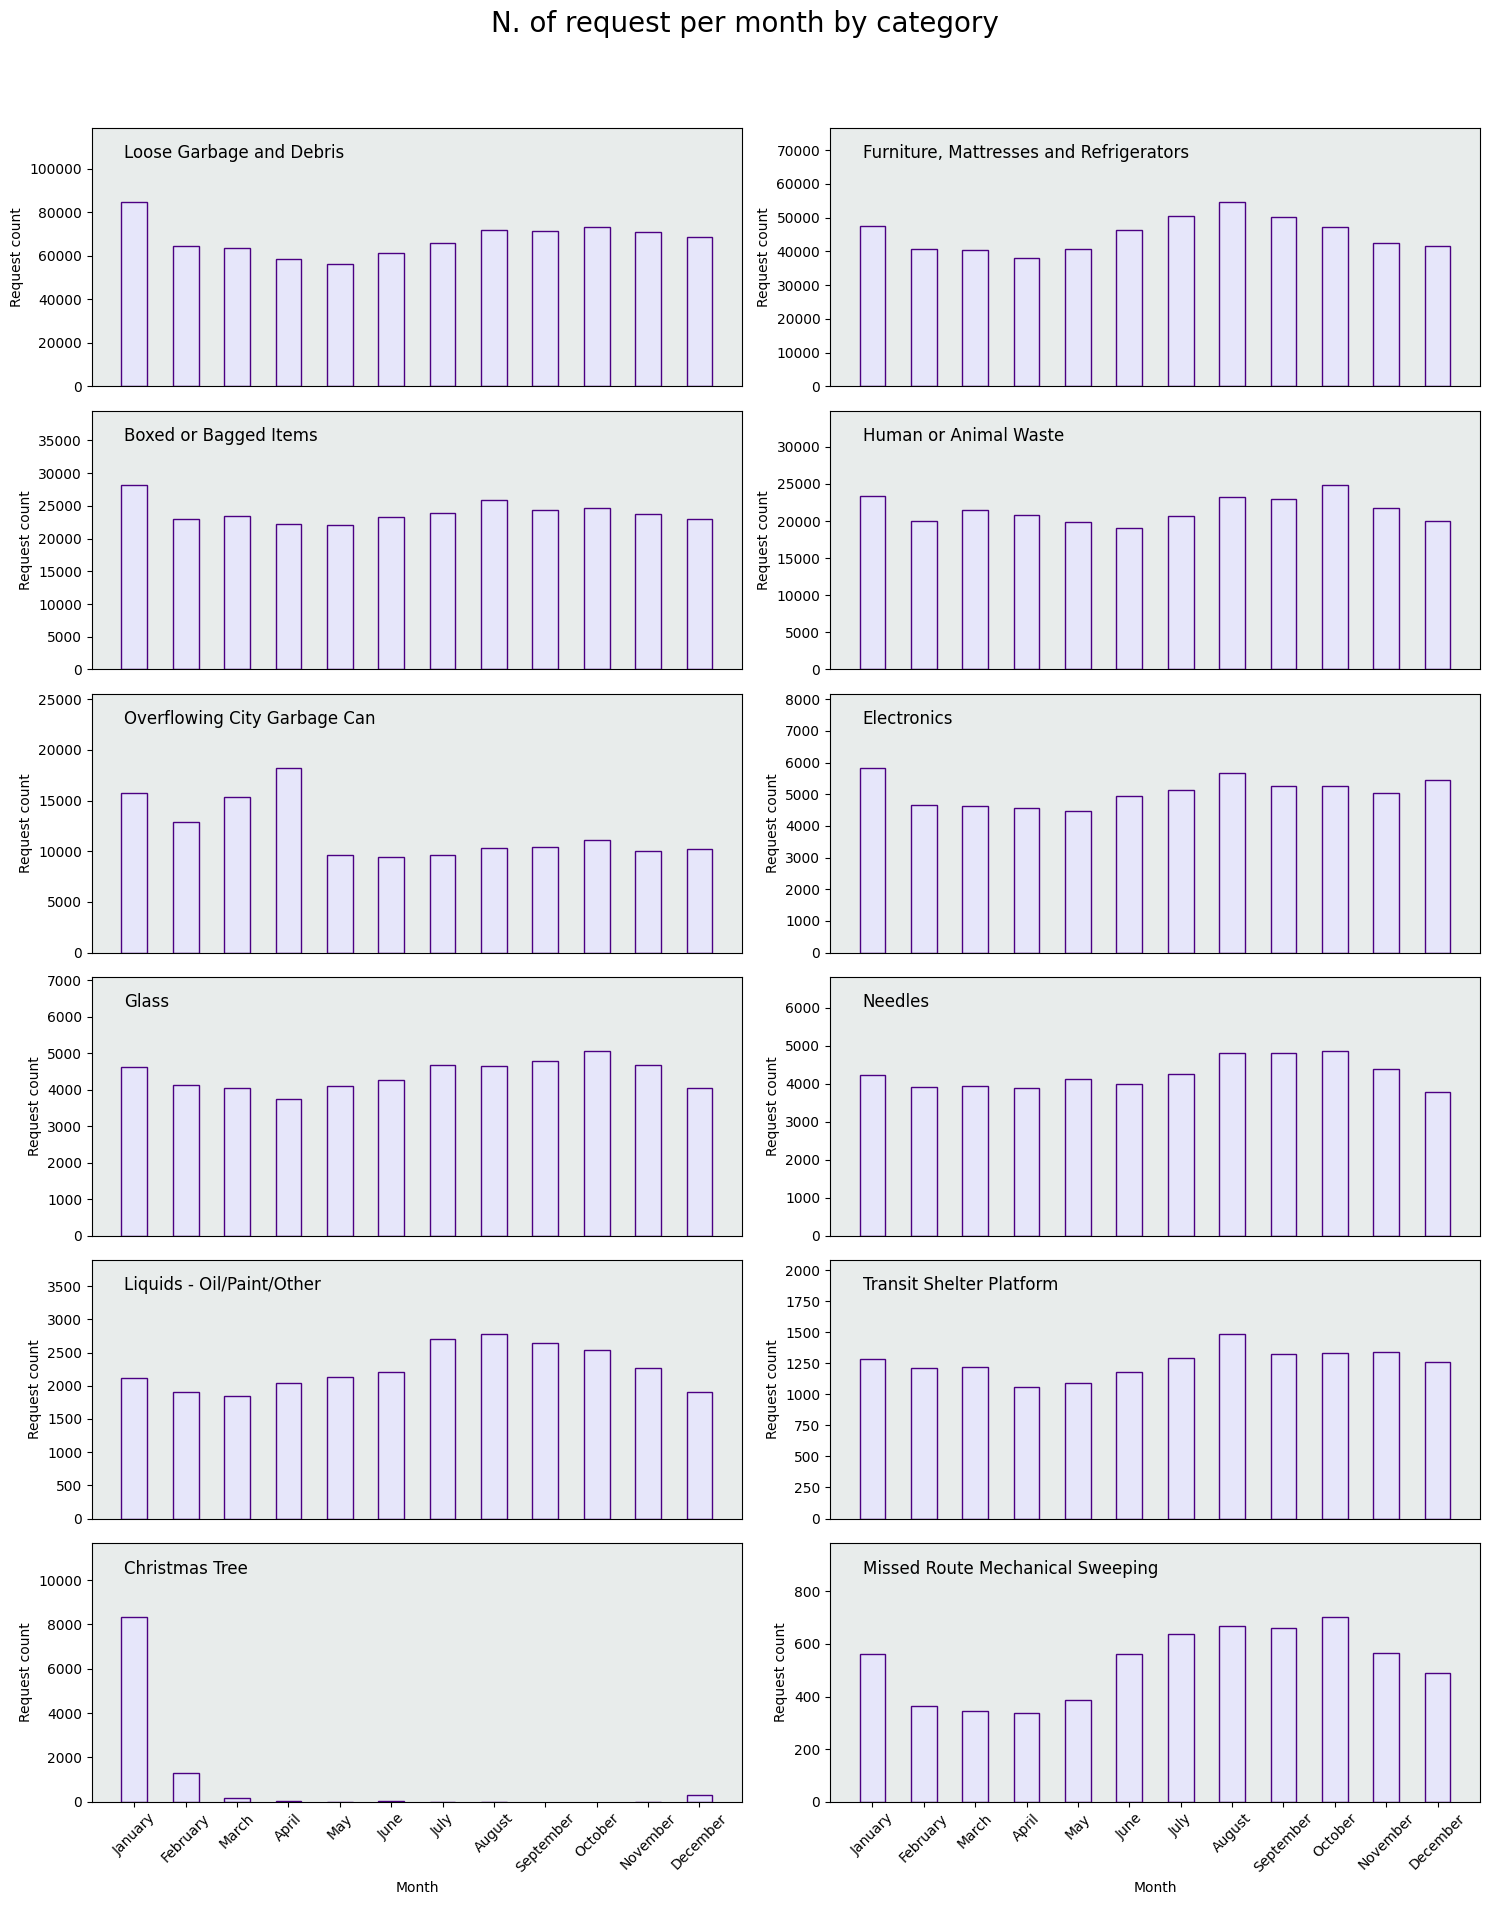

In [8]:
# Get month from datetime
custom_df = df.copy()
custom_df['Month'] = custom_df['Date'].dt.month

# Define custom variables
plt_title = 'N. of request per month by category'
ylabel = 'Request count'
xlabel = 'Month'
xticks = custom_df['Month'].unique()
xticks.sort() 
xticklabels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot data
plot_category_subset('Month', custom_df, focus_categories, plt_title, ylabel, xlabel, xticks, xticklabels)

### 24-hour cycle plots

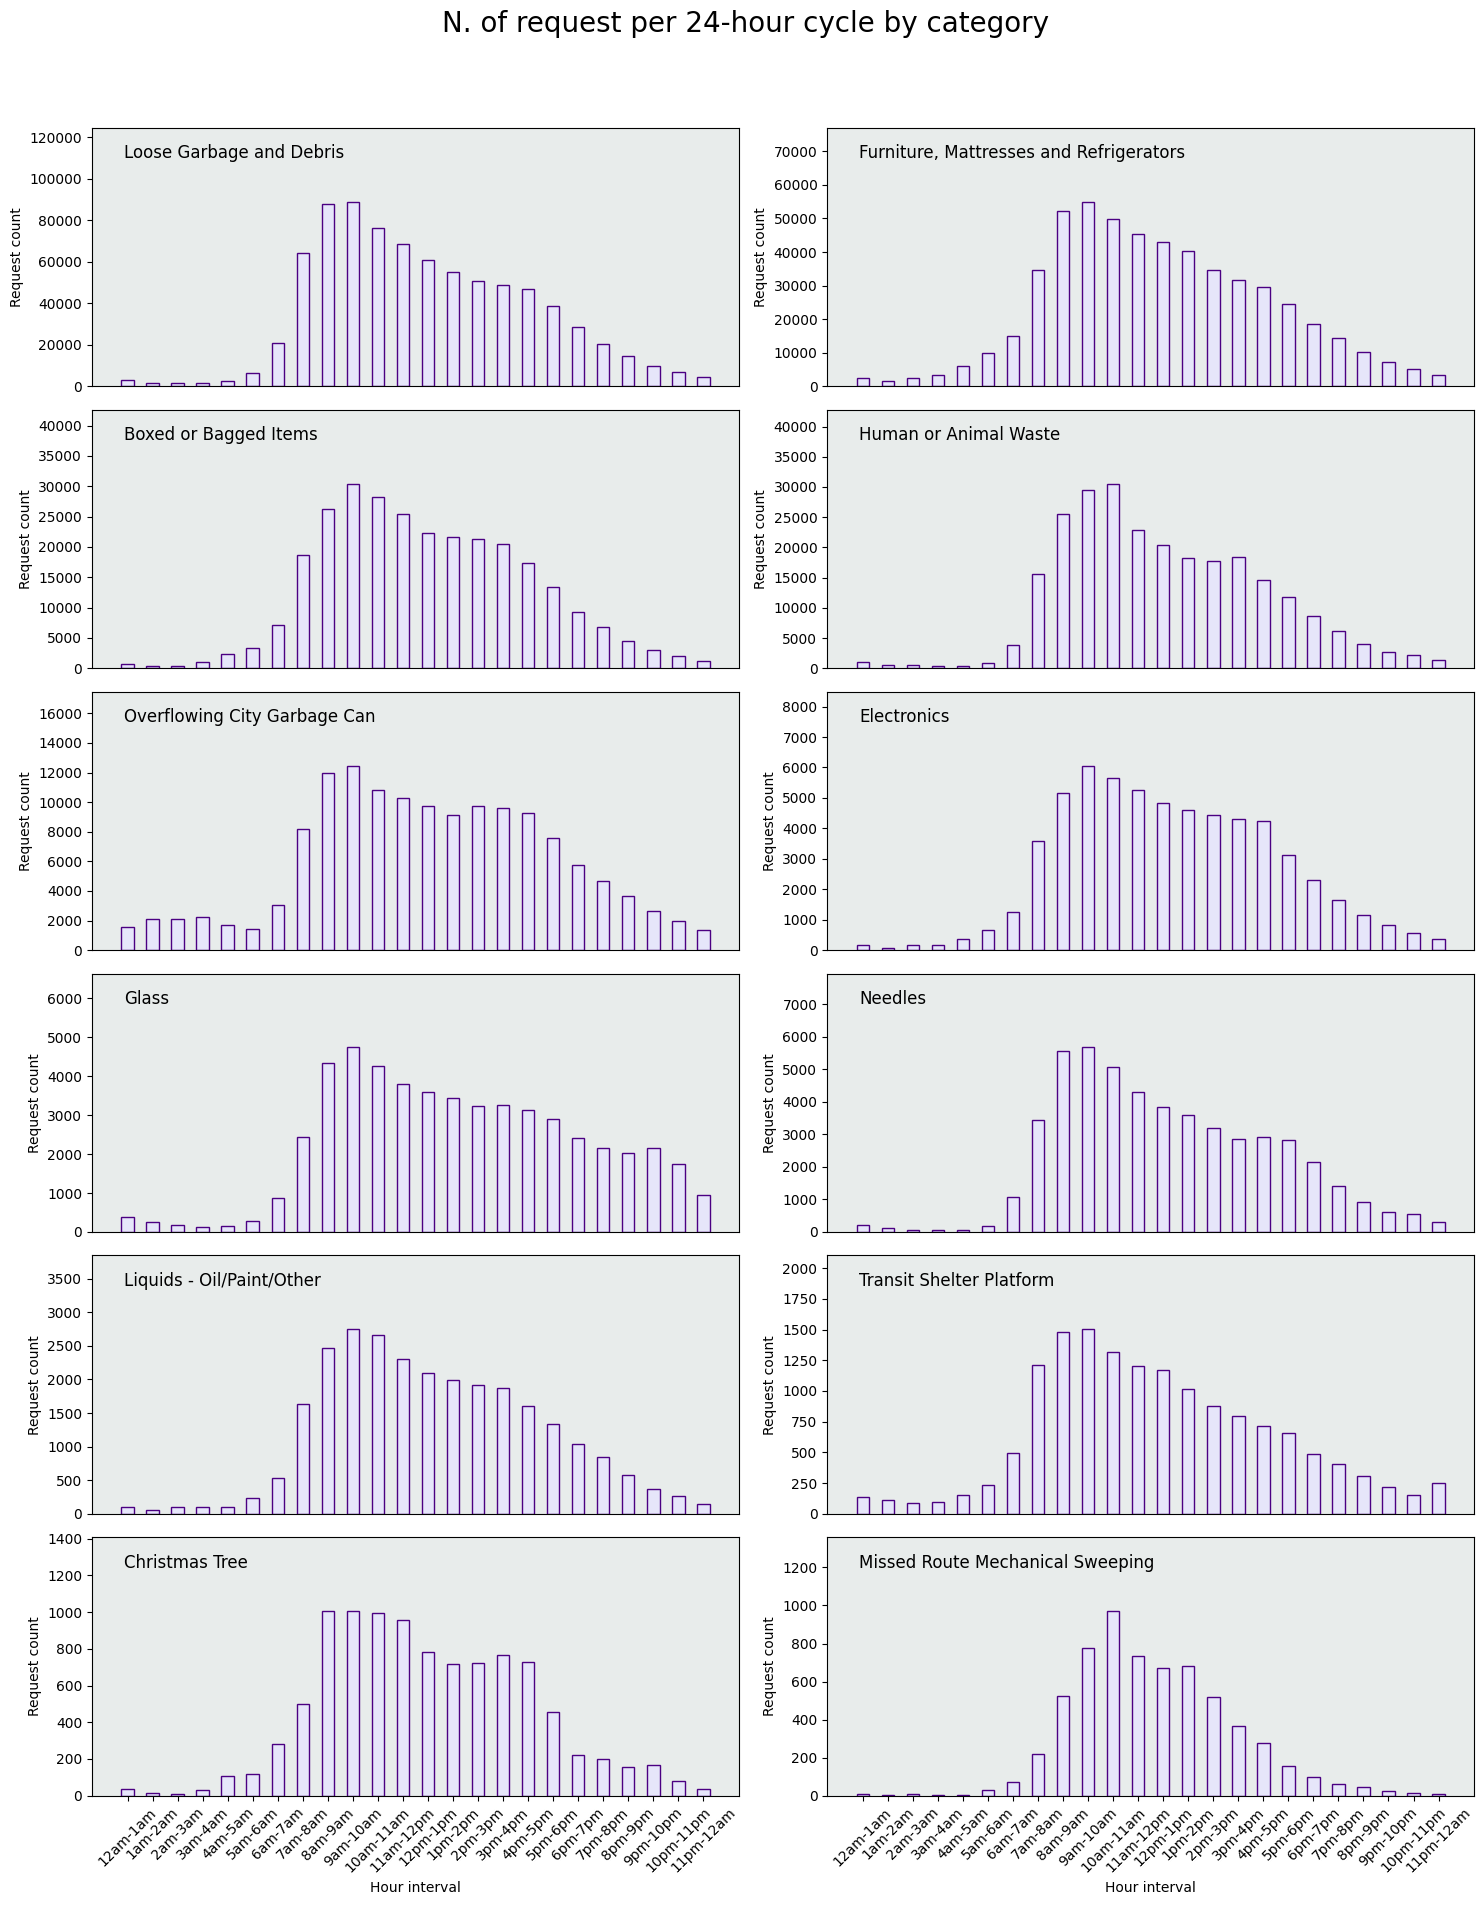

In [9]:
# Create variables for xticks
hours = [*range(0,24)]
hours_12_to_1 = [12] + [*range(1,12)]
hours_labels_am = [f'{str(hours_12_to_1[i])}am-{str(hours_12_to_1[i+1])}am' for i in range(len(hours_12_to_1) - 1)]
hours_labels_pm = [f'{str(hours_12_to_1[i])}pm-{str(hours_12_to_1[i+1])}pm' for i in range(len(hours_12_to_1) - 1)]
hours_labels = hours_labels_am + ['11am-12pm'] + hours_labels_pm + ['11pm-12am']

# Convert DayOfWeek column to categorical data type with custom order
custom_df = df.copy()
custom_df['HourInterval'] = df['Time'].astype(str).str[:2].astype(int)

# Define custom variables
plt_title = 'N. of request per 24-hour cycle by category'
ylabel = 'Request count'
xlabel = 'Hour interval'
xticks = hours
xticklabels = hours_labels

# Plot data
plot_category_subset('HourInterval', custom_df, focus_categories, plt_title, ylabel, xlabel, xticks, xticklabels)

For needles there’s a peak between 8 and 10 am that is when people go to work and kids to school. During the day the requests tend to go down, meaning that 311 is probably taking action and removing the needles, and thus getting less reports. Because by the time people leave work and school the reports go to almost half that in the morning. The same thing happens for Human or Animal waste, and most of the categories.

### 168 hours plots

<ipython-input-10-6ef6934be321>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Purples')


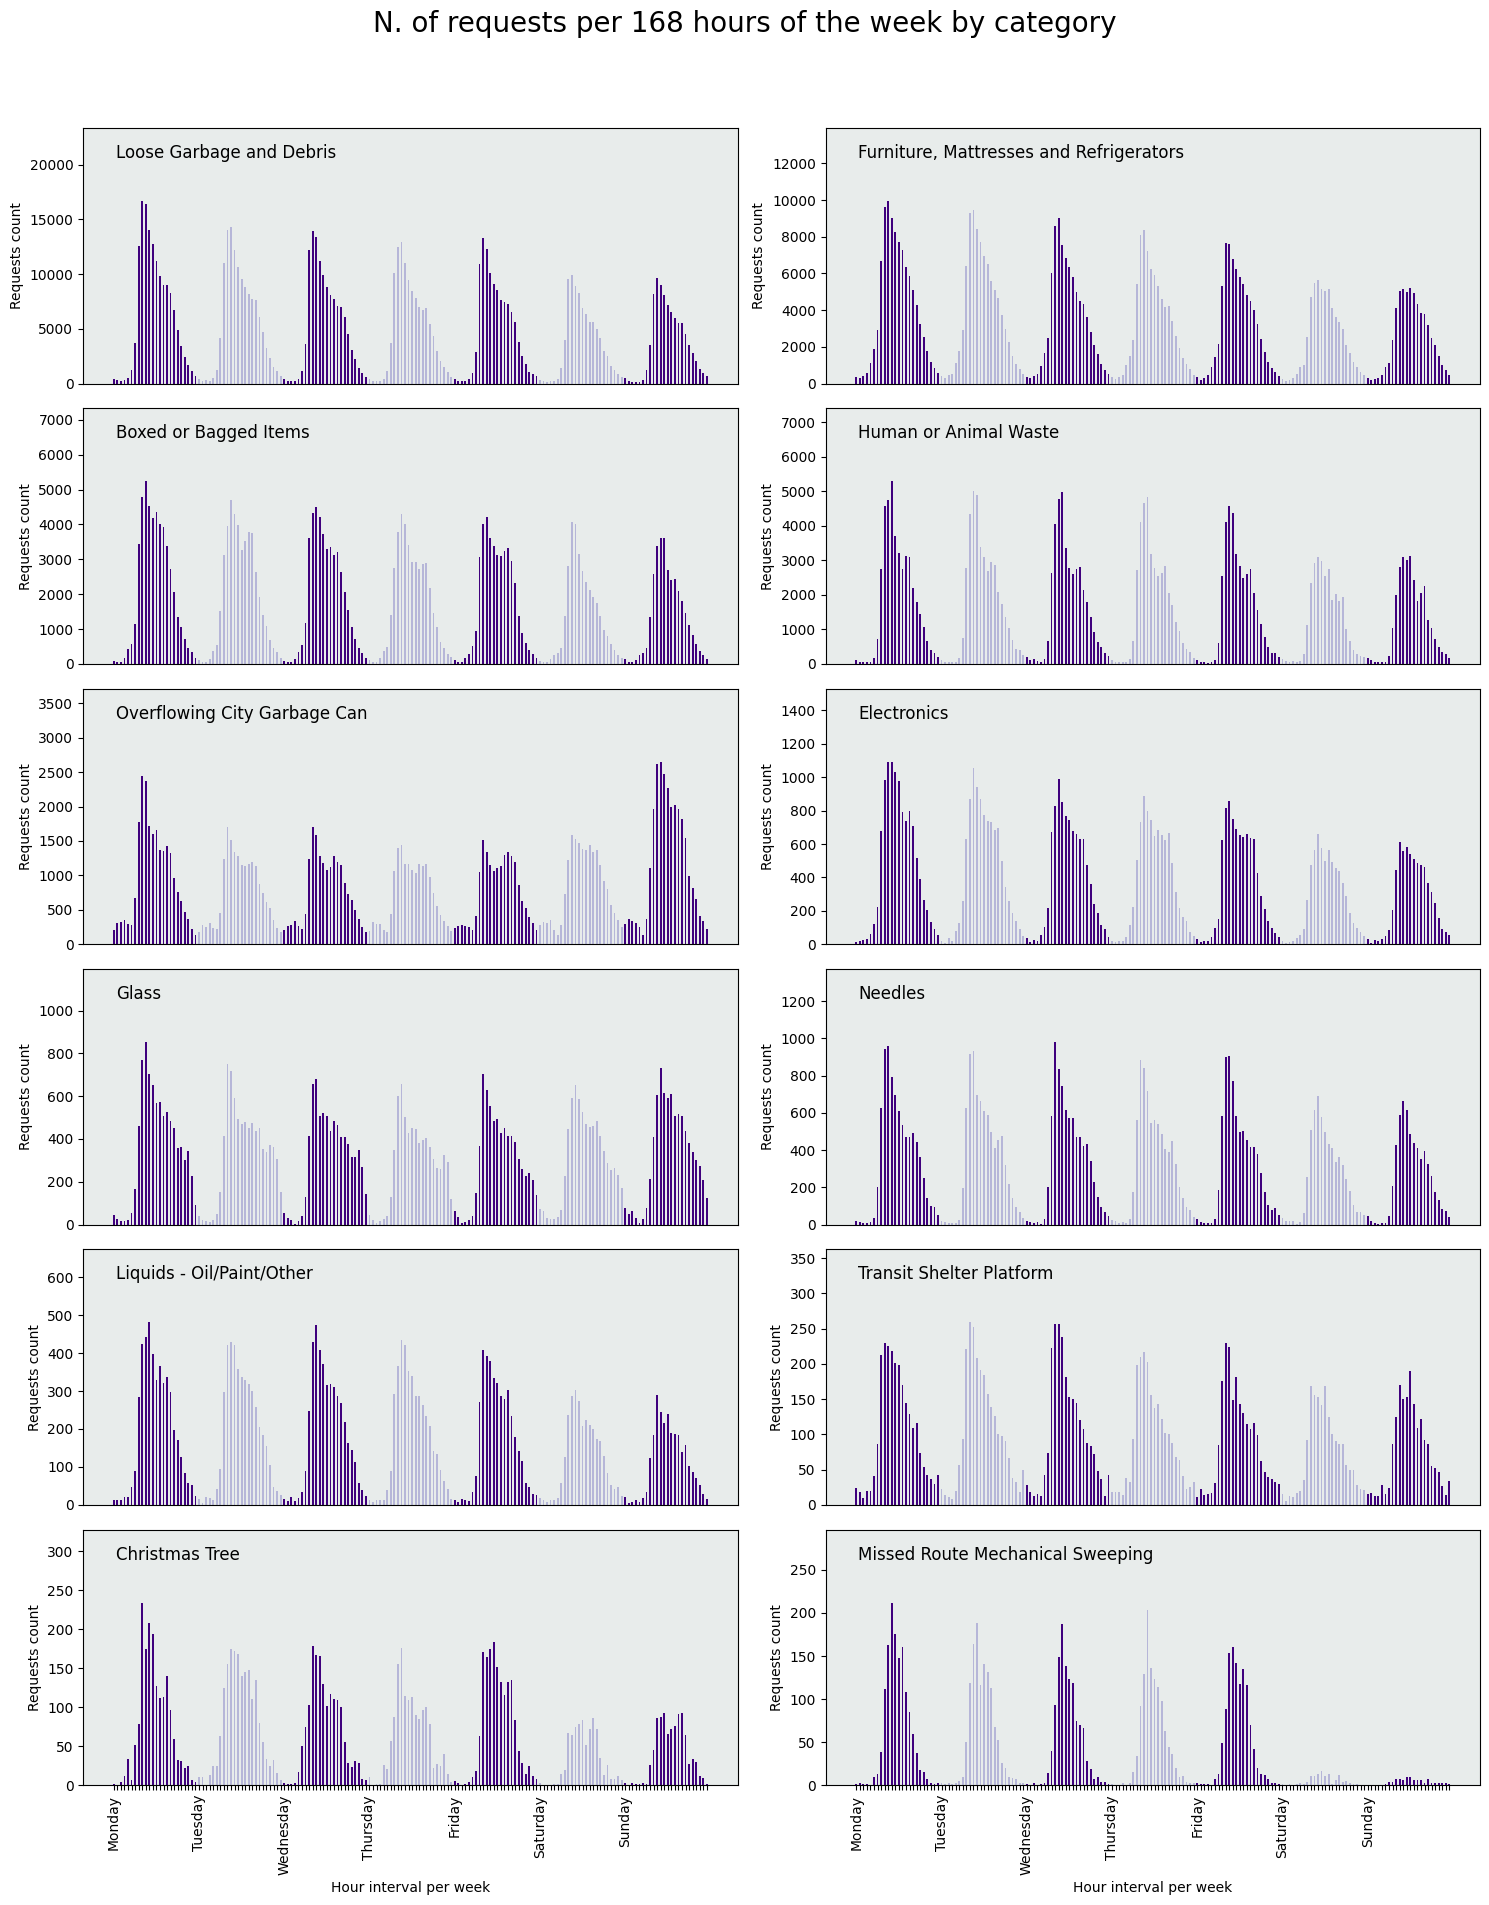

In [10]:
def plot_week_hours_by_category(df, focuscrimes, plt_title, ylabel, xlabel, xticks, xticklabels):
    grouped = df.groupby(['Request Details', 'DayOfWeek', 'HourInterval'])['Opened'].agg('count')
    focus_subset = grouped[focuscrimes].reset_index()

    # Sort values by Category, DayOfWeek and HourInterval
    focus_subset = focus_subset.sort_values(['Request Details', 'DayOfWeek', 'HourInterval'])

    # Plot data
    cols = 2
    fig, axs = plt.subplots(int(len(focuscrimes)/cols), cols, figsize=(15,20))
    axs = axs.flatten()

    # Define a colormap with different alpha values for alternate days of the week
    transparencies = [1, 0.4]
    alpha = []
    for i in range(7): # For each day of the week add the corresponding transparency to the colormap
        trans_len = len(transparencies)
        alpha += [transparencies[i%trans_len]] * 24 # 24 hours for each day
    cmap = plt.cm.get_cmap('Purples')
    colors = cmap(alpha)

    # Make subplots for each category
    for i, category in enumerate(focus_categories):
        category_data = focus_subset[focus_subset['Request Details'] == category]
        axs[i].bar(category_data['DayOfWeek'].astype(str) + '-' + category_data['HourInterval'].astype(str), category_data['Opened'], width=0.5, color=colors)
        axs[i].set_title(category, x=0.05, y=0.85, horizontalalignment='left')
        axs[i].set_ylabel(ylabel)
        axs[i].set_xticks([])
        axs[i].set_ylim(0, category_data.Opened.max()*1.4)

        # Show xlabels for the last row in the plot
        if i >= len(focus_categories) - cols:
            axs[i].set_xlabel(xlabel)
            axs[i].set_xticks(xticks)
            axs[i].set_xticklabels(day_start, rotation=90)

    plt.suptitle(plt_title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # avoid text overlapping
    plt.show()


# Create variables for xticks
day_start = []
for day in ordered_days:
        day_start.append(day)
        day_start += [None]*23

# Create necessary variables
custom_df = df.copy()
custom_df['DayOfWeek'] = custom_df['DayOfWeek'].astype(day_order)
custom_df['HourInterval'] = df['Time'].astype(str).str[:2].astype(int)

# Define custom variables
plt_title = 'N. of requests per 168 hours of the week by category'
ylabel = 'Requests count'
xlabel = 'Hour interval per week'
xticks = [*range(168)]
xticklabels = day_start

# Plot data
plot_week_hours_by_category(custom_df, focus_categories, plt_title, ylabel, xlabel, xticks, xticklabels)

### Calendar plot

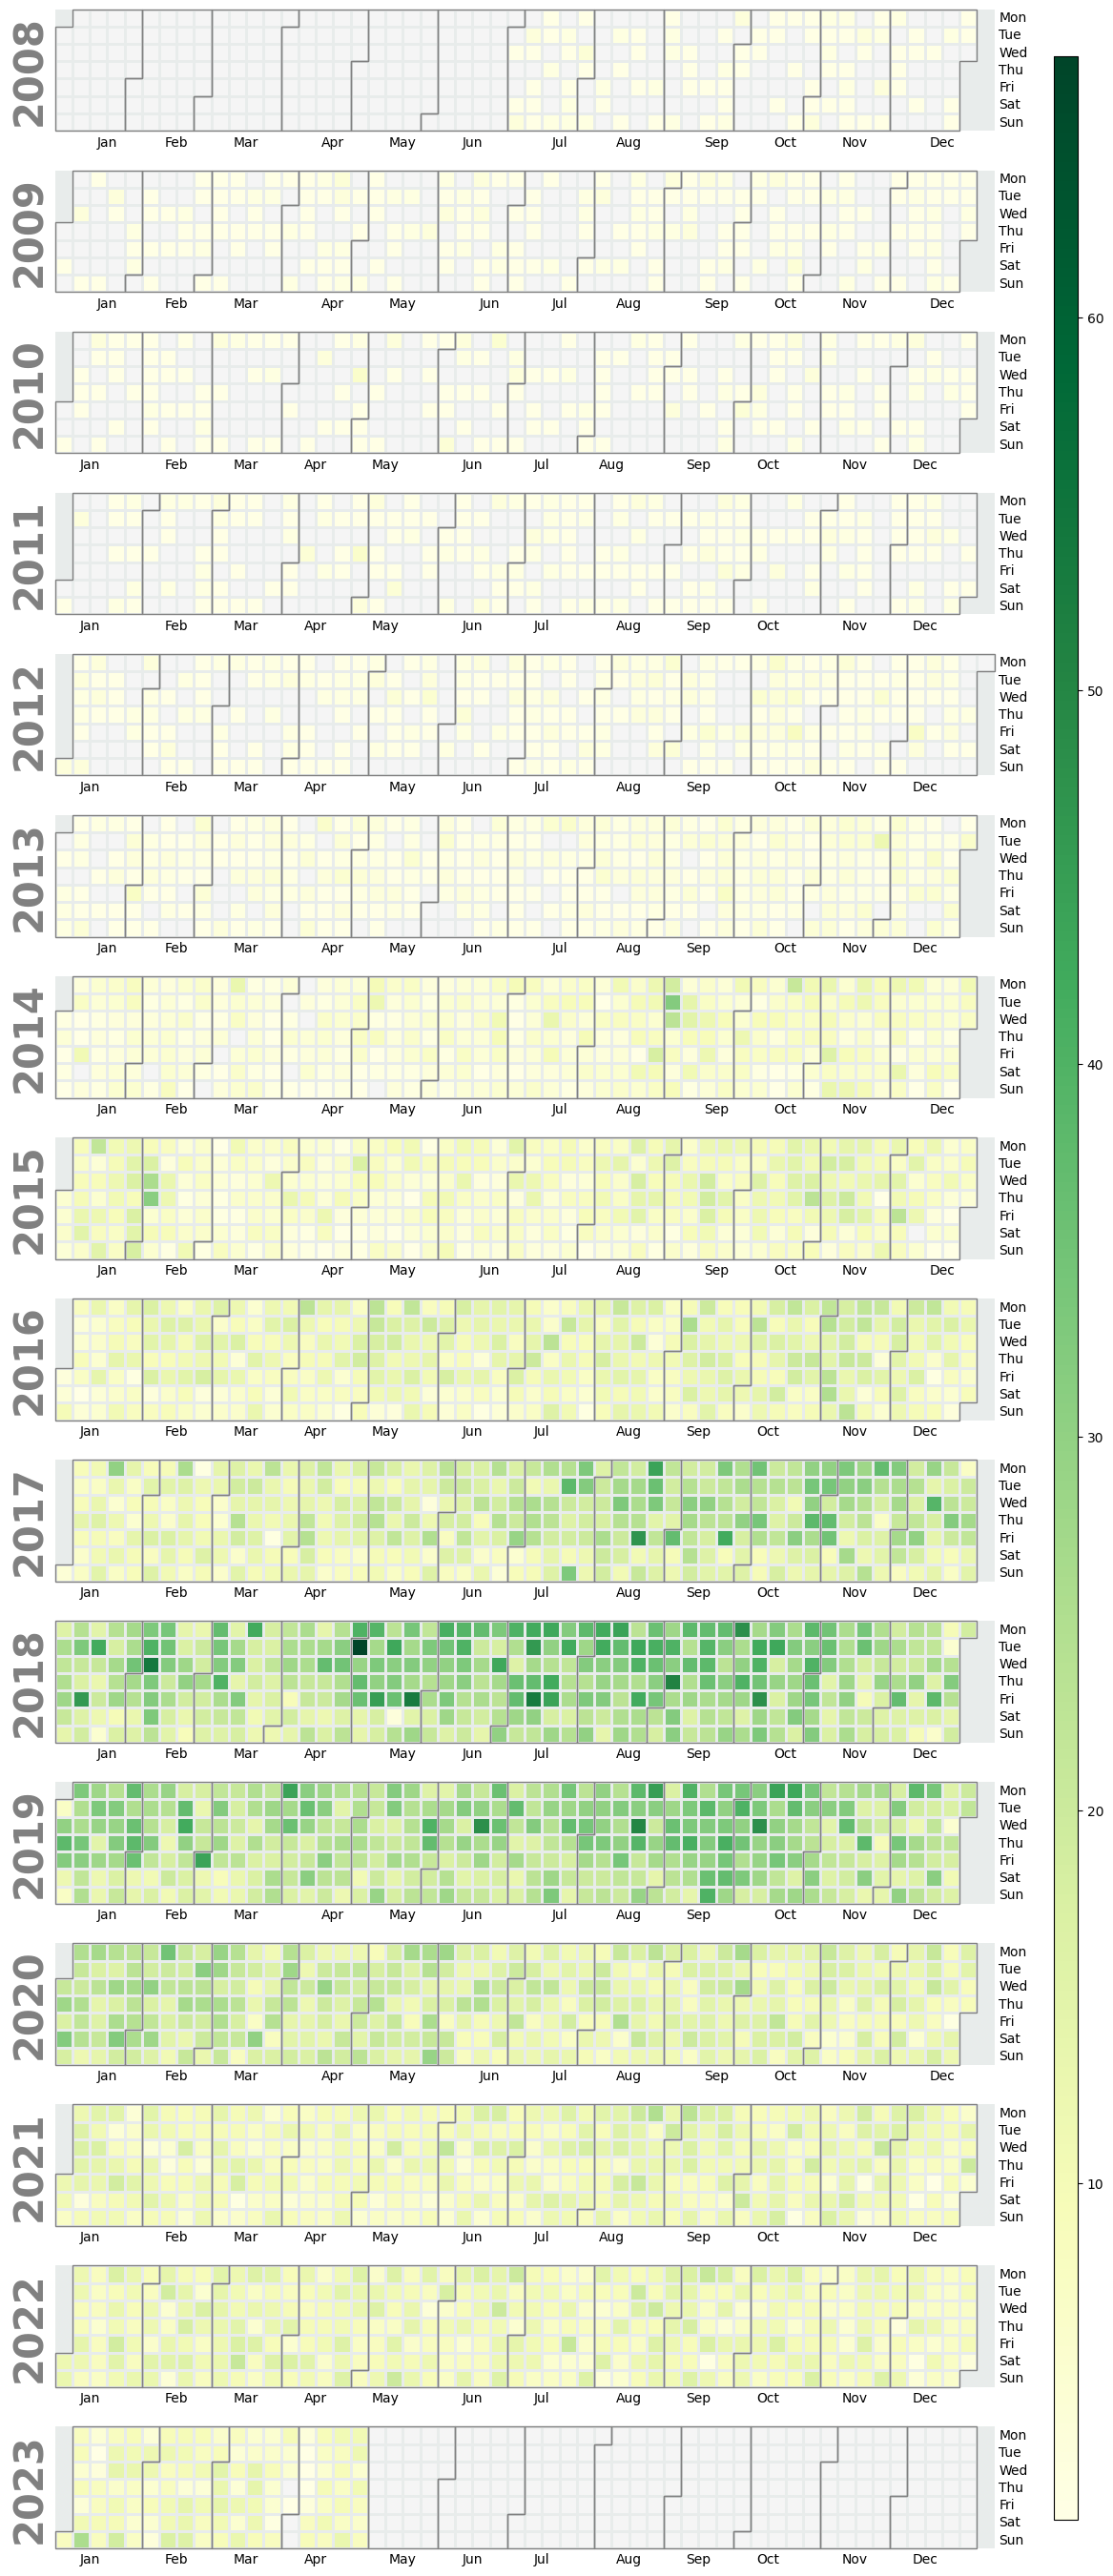

In [11]:
def calendar_plot_category(focus_category):
    # Choose category
    focus_subset = df[df['Request Details'] == focus_category]

    # Focus on Date and crimes column
    focus_subset = focus_subset[['Date', 'Opened']]

    # Set first and last year to show
    first_year = focus_subset['Date'].dt.year.min()
    last_year = focus_subset['Date'].dt.year.max()

    # Set date as index
    focus_subset = focus_subset.set_index('Date')
    # Count the number of crimes per day and store in events
    events = focus_subset.index.value_counts().replace(0,)

    # Plot events, dropzero=True is used to not fill a color for days with a zero value
    calplot.calplot(events, cmap='YlGn', dropzero=True)

    plt.show()

calendar_plot_category('Needles')

As seen in the bar plots, weekends tend to have less reports.

### Polar plot

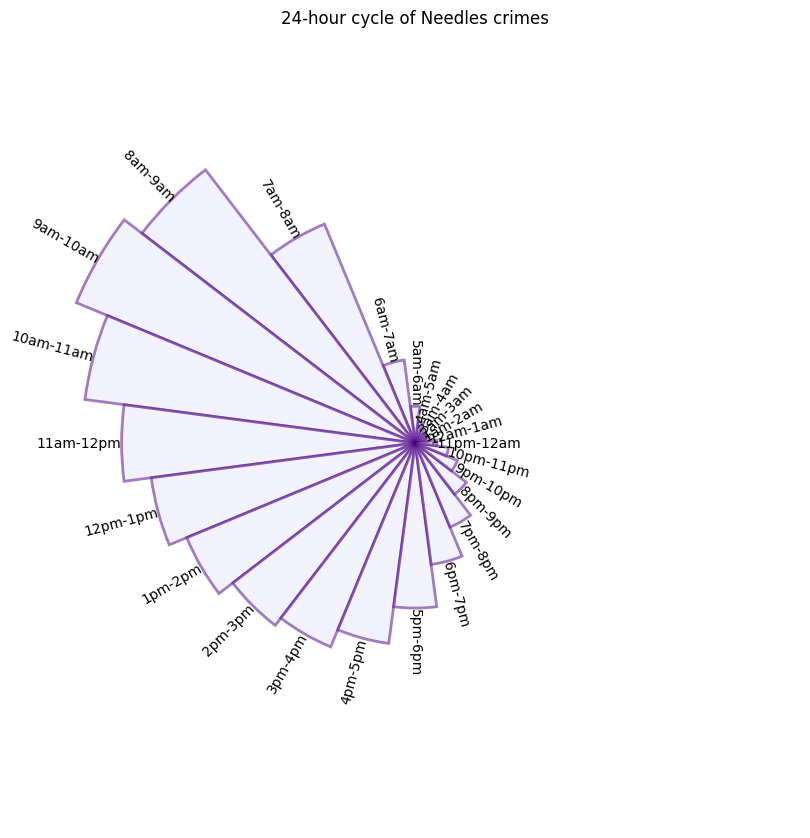

In [12]:
def polar_bar_plot_category(df, focus_cat, sort_by_value=True):
    # Group by category and hour interval
    grouped = df[df['Request Details'] == focus_cat]
    grouped = df.groupby('HourInterval')['Opened'].agg('count').sort_index()
    # Convert series to dataframe to add the name each value will have in the plot, and being able to sort by value
    grouped = grouped.to_frame()
    grouped['HourIntervalsNames'] = hours_labels

    if sort_by_value:
        grouped = grouped.sort_values('Opened')

    # set figure size
    plt.figure(figsize=(20,10))

    # plot polar axis
    ax = plt.subplot(111, polar=True)

    # remove grid
    plt.axis('off')

    # Set the coordinates limits
    upperLimit = 100
    lowerLimit = 30

    # Compute max and min in the dataset
    max = grouped['Opened'].max()

    # Let's compute heights: they are a conversion of each item value in those new coordinates
    # In our example, 0 in the dataset will be converted to the lowerLimit (10)
    # The maximum will be converted to the upperLimit (100)
    slope = (max - lowerLimit) / max
    heights = slope * grouped['Opened'] + lowerLimit 

    # Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(grouped.index) # Note: angles are provided in radians. Remember that 0 degrees is 0 radians. 180 degrees is Pi radians. And so on.

    # Compute the angle each bar is centered on:
    indexes = list(range(1, len(grouped.index)+1))
    angles = [element * width for element in indexes]

    # Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=2, 
        alpha=0.5,
        edgecolor="indigo",
        color="lavender",
        )

    # little space between the bar and the label
    labelPadding = 4
    
    # Add title
    ax.set_title(f"24-hour cycle of {focus_cat} crimes")

    # Add labels
    for bar, angle, height, label in zip(bars,angles, heights, grouped['HourIntervalsNames']):
        # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

        # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor")

polar_bar_plot_category(custom_df, 'Needles',  sort_by_value=False)